In [60]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import cross_val_multiscore, LinearModel, GeneralizingEstimator, Scaler
# from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
#                           cross_val_multiscore, LinearModel,
#                           Vectorizer) #Scaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC


# Read MNE sample data

In [3]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
tmin, tmax = -0.200, 0.500
event_id = {'Auditory/Left': 1, 'Visual/Left': 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.filter(2, 20)
events = mne.find_events(raw, 'STI 014')
# Set up pick list: EEG + MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more
# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                     baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=10)
epochs.pick_types(meg=True, exclude='bads')  # remove stim and EOG

X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right


Opening raw data file /Users/Maryam/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Setting up band-pass filter from 2 - 20 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 991 samples (1.650 sec) selected
320 events found
Event IDs: [ 1  2  3  4  5 32]
145 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 145 events and 421 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch base

In [8]:
# scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=1)
# # Mean scores across cross-validation splits
# scores = np.mean(scores, axis=0)

In [10]:
# clf = make_pipeline(StandardScaler(),
#                     LinearModel(LogisticRegression(solver='lbfgs')))
# # define the Temporal generalization object
# time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)

# Plot functions

In [48]:
def plot_scores(scores):
    fig, ax = plt.subplots(1, 1)
    plt.tight_layout()
    im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=epochs.times[[0, -1, 0 , -1]], vmin=0., vmax=1.)
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('Temporal generalization')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def plot_scores_diag(scores_diag):
    fig, ax = plt.subplots()
    ax.plot(epochs.times, scores_diag, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.set_ylabel('AUC')  # Area Under the Curve
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('Sensor space decoding')
    plt.tight_layout()
    plt.show()
    

# General decoder params

In [68]:
nSplits=5
scoring='roc_auc'
randState=0
maxIter=10000

# Set up a decoder


## Using StandardScaler from sklearn.preprocessing:
### mne.decoding.Scaler
    scales each channel 
    using mean and standard deviation computed across all of its time points and epochs. 
###  sklearn.preprocessing.StandardScaler offered by scikit-learn
    These scale each classification feature, e.g. each time point for each channel, 
    with mean and standard deviation computed across epochs

In [15]:
le = LabelEncoder()
clf_SVC  = make_pipeline(
                        StandardScaler(),
                        LinearModel(LinearSVC(random_state=0, max_iter=10000)))

In [18]:
time_gen = GeneralizingEstimator(clf_SVC, scoring='roc_auc', n_jobs=1,verbose=True)

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

## 1. Getting scores using cross val multiscore from sklearn package

In [44]:
score_wcv = cross_val_multiscore(time_gen, X, y, cv=cv, n_jobs=1)
score_wcv = np.mean(score_wcv, axis=0) #scores with cv
score_diag_wcv = np.diag(score_wcv)
score_substract_wcv = score_diag_wcv - 0.5
scores_wcv = (score_wcv.copy(), score_diag_wcv.copy(), score_substract_wcv.copy())

[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[.............................................

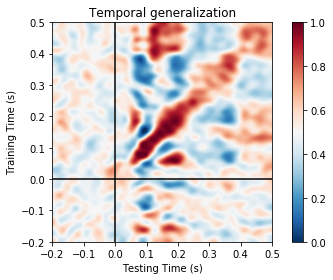

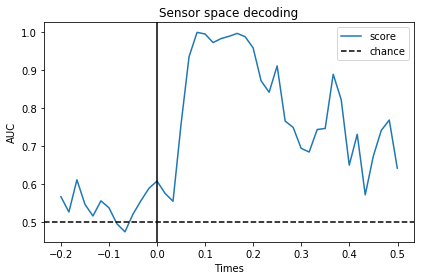

In [49]:
plot_scores(scores_wcv[0])
plot_scores_diag(scores_wcv[1])

## 2. Getting scores after fit/train

In [50]:
X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right

time_gen.fit(X=X ,y=y)
score_wocv = time_gen.score(X=X, y=y) #scores without cv
score_diag_wocv = np.diag(score_wocv)
scores_wocv = (score_wocv.copy(), score_diag_wocv.copy())

[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   


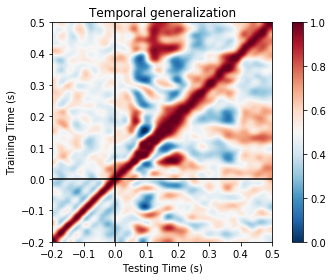

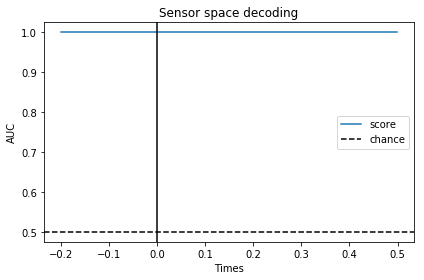

In [51]:
plot_scores(scores_wocv[0])
plot_scores_diag(scores_wocv[1])

## 3. Set up a decoder using Scaler from mne decoding

In [61]:
le = LabelEncoder()
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LinearModel(LinearSVC(random_state=randState, max_iter=maxIter)))

In [62]:
time_gen = GeneralizingEstimator(clf, scoring=scoring, n_jobs=1,verbose=True)

In [63]:
cv = StratifiedKFold(n_splits=nSplits, shuffle=True)

In [64]:
score2_wcv = cross_val_multiscore(time_gen, X, y, cv=cv, n_jobs=1)
score2_wcv = np.mean(score2_wcv, axis=0) 
score2_diag_wcv = np.diag(score2_wcv)
scores2_wcv = (score2_wcv.copy(), score2_diag_wcv.copy())

[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[.............................................

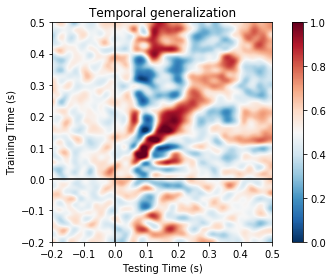

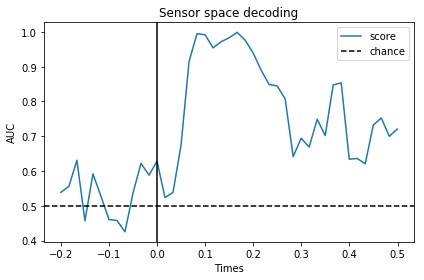

In [66]:
plot_scores(scores2_wcv[0])
plot_scores_diag(scores2_wcv[1])

## 4. Set up a decoder using diff cv and repeatedStritifiedKFold from sklearn

In [70]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [71]:
cv = RepeatedStratifiedKFold(n_splits=nSplits, n_repeats=3, random_state=randState)

In [82]:
score_rskf_o = cross_val_multiscore(time_gen, X, y, cv=cv, n_jobs=1)

[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[.............................................

In [83]:
print(score_rskf_o.shape)
score_rskf = np.mean(score_rskf_o, axis=0) 
score_diag_rskf = np.diag(score_rskf)
scores_rskf = (score_rskf.copy(), score_diag_rskf.copy())

(15, 43, 43)


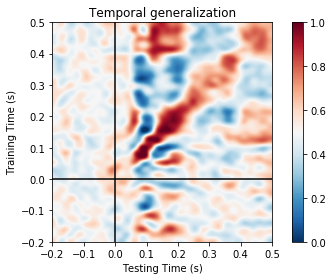

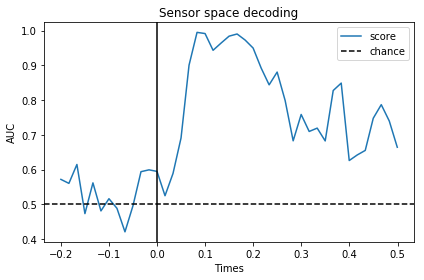

In [84]:
plot_scores(score_rskf)
plot_scores_diag(score_diag_rskf)